# Data Programming Project - GDP Analysis

In this project, we are investigating the dataset of countries of the world. The source of our data is The World Bank and CIA Factbook. We will be focusing on factors affecting a country’s GDP per capita, and use linear regression and random forest regression for predictive modeling.

In [1]:
import numpy as np
import pandas as pd
import statistics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, explained_variance_score, r2_score

world_data = pd.read_csv("World.csv", index_col=0)
world_data.head()

,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Migration rate,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Mobile Cellular Subscription per 100,Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
Country,,,,,,,,,,,,,,,,,,,
Afghanistan,ASIA (EX. NEAR EAST),38041754,647500,58.75,0.00,-0.83,46.50,507.10,43.02,59.36,12.13,0.22,87.65,1.0,32.49,6.42,25.77,14.00,55.47
Albania,EASTERN EUROPE,2854191,28748,99.28,1.26,-2.45,8.60,5353.24,98.14,91.29,21.09,4.42,74.49,3.0,11.78,7.90,18.47,20.00,49.00
Algeria,NORTHERN AFRICA,43053054,2381740,18.08,0.04,-0.12,20.00,3973.96,81.41,109.36,3.22,0.25,96.53,1.0,24.28,4.72,12.38,37.44,46.00
American Samoa,OCEANIA,55312,199,277.95,58.29,0.00,10.25,11466.70,97.34,NaN,10.00,15.00,75.00,2.0,NaN,NaN,27.40,12.40,NaN
Andorra,WESTERN EUROPE,77142,468,164.83,0.00,0.00,2.80,40886.39,NaN,113.96,2.22,0.00,97.78,3.0,7.20,4.40,11.90,33.60,NaN


# Missing values

We see that some of the values are missing (NaN) in the datatable. Let's get an overview of missing values.


In [2]:
world_data.isnull().sum()

Region                                   0
Population                               0
Area (sq. mi.)                           0
Pop. Density (per sq. mi.)               0
Coastline (coast/area ratio)             0
Migration rate                          25
Infant mortality (per 1000 births)       6
GDP ($ per capita)                       3
Literacy (%)                             7
Mobile Cellular Subscription per 100    29
Arable (%)                               2
Crops (%)                                2
Other (%)                                0
Climate                                 22
Birthrate                               33
Deathrate                               34
Agriculture                             12
Industry                                 9
Service                                 32
dtype: int64

# Data preparation - filling the missing values

For simplicity, we will fill the missing data using the median of the region that a country belongs, as countries that are close geologically are often similar in many ways.

Note that for 'climate' we use the mode instead of median as it seems that 'climate' is a categorical feature here.

In [3]:
world_data.groupby('Region')[['GDP ($ per capita)','Literacy (%)','Agriculture']].median()

,GDP ($ per capita),Literacy (%),Agriculture
Region,,,
ASIA (EX. NEAR EAST),3994.325,94.310,10.800
BALTICS,19601.890,99.880,3.220
C.W. OF IND. STATES,4660.215,99.730,8.255
EASTERN EUROPE,13927.815,98.840,3.300
LATIN AMER. & CARIB,12271.905,94.395,4.800
NEAR EAST,12234.810,95.855,2.375
NORTHERN AFRICA,3317.450,79.000,11.050
NORTHERN AMERICA,54471.000,99.000,1.250
OCEANIA,7786.435,98.000,7.925


In [5]:
for col in world_data.columns.values:
    if world_data[col].isnull().sum() != 0:
        if col == 'Climate':
            guess_values = world_data.groupby('Region')['Climate'].apply(lambda x: statistics.mode(x))
        else:
            guess_values = world_data.groupby('Region')[col].median()
        for region in world_data['Region'].unique():
            world_data[col].loc[(world_data[col].isnull())&(world_data['Region']==region)] = guess_values[region]
            
world_data.isnull().sum()

Region                                  0
Population                              0
Area (sq. mi.)                          0
Pop. Density (per sq. mi.)              0
Coastline (coast/area ratio)            0
Migration rate                          0
Infant mortality (per 1000 births)      0
GDP ($ per capita)                      0
Literacy (%)                            0
Mobile Cellular Subscription per 100    0
Arable (%)                              0
Crops (%)                               0
Other (%)                               0
Climate                                 0
Birthrate                               0
Deathrate                               0
Agriculture                             0
Industry                                0
Service                                 0
dtype: int64

In [6]:
world_data.describe()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Migration rate,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Mobile Cellular Subscription per 100,Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.240000e+02,2.240000e+02,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,3.444694e+07,6.050390e+05,475.210759,21.200045,-0.059219,19.271696,18980.470900,87.823571,108.878638,13.882679,4.471607,81.756786,2.185268,19.690580,7.454241,10.016250,24.643304,56.851027
std,1.359771e+08,1.801247e+06,2163.192242,72.732339,2.654650,18.288012,26976.135346,16.816220,39.560582,13.032832,8.267704,16.203364,0.724527,9.506493,2.537692,10.771128,11.680842,13.138858
min,4.994000e+03,2.000000e+00,0.030000,0.000000,-15.340000,1.500000,261.250000,22.310000,14.980000,0.000000,0.000000,33.330000,1.000000,5.900000,1.200000,0.000000,0.000000,0.000000
25%,5.759648e+05,5.609500e+03,34.612500,0.097500,-0.510000,5.600000,2680.187500,82.340000,86.557500,3.460000,0.190000,72.150000,2.000000,10.975000,6.000000,2.047500,16.000000,49.540000
50%,5.880321e+06,8.748050e+04,90.085000,0.725000,-0.120000,12.345000,7726.480000,96.100000,108.722500,10.475000,1.005000,86.460000,2.000000,17.310000,7.000000,5.810000,23.660000,57.810000
75%,2.344403e+07,4.467625e+05,221.482500,10.332500,0.465000,27.700000,25595.795000,99.000000,129.410000,20.000000,4.432500,95.587500,3.000000,26.875000,8.922500,14.580000,30.000000,66.000000
max,1.397715e+09,1.707520e+07,22873.040000,870.660000,14.560000,81.000000,185829.000000,100.000000,345.330000,62.110000,50.680000,100.000000,4.000000,46.080000,15.400000,60.200000,63.000000,94.000000


# Let's look at the top countries and regions with highest GDP per capita

Text(0, 0.5, 'GDP per capita ($)')

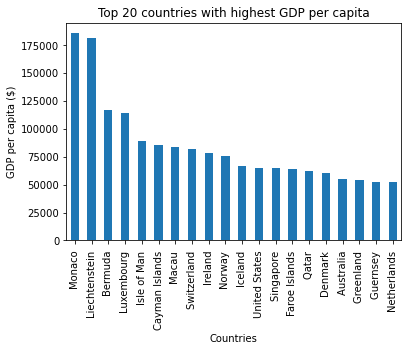

In [7]:
my_plot = world_data["GDP ($ per capita)"].nlargest(20).plot(kind='bar',legend=None,title="Top 20 countries with highest GDP per capita")
my_plot.set_xlabel("Countries")
my_plot.set_ylabel("GDP per capita ($)")

Text(0, 0.5, 'Share')

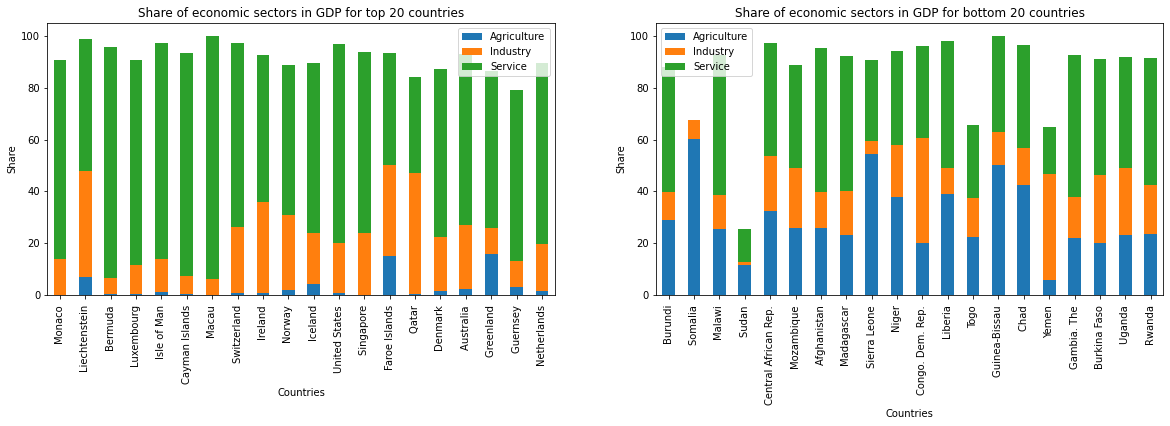

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

my_plot = world_data[["GDP ($ per capita)","Agriculture", "Industry", "Service"]].nlargest(20, "GDP ($ per capita)").drop('GDP ($ per capita)', axis=1).plot(kind='bar',stacked=True,ax=axes[0],title="Share of economic sectors in GDP for top 20 countries")
my_plot.set_xlabel("Countries")
my_plot.set_ylabel("Share")

my_plot = world_data[["GDP ($ per capita)","Agriculture", "Industry", "Service"]].nsmallest(20, "GDP ($ per capita)").drop('GDP ($ per capita)', axis=1).plot(kind='bar',stacked=True,ax=axes[1],title="Share of economic sectors in GDP for bottom 20 countries")
my_plot.set_xlabel("Countries")
my_plot.set_ylabel("Share")

Text(0, 0.5, 'GDP per capita ($)')

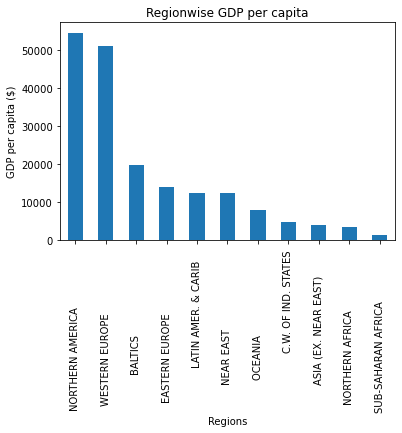

In [9]:
total_regions = len(world_data["Region"].unique())
my_plot = world_data.groupby("Region")["GDP ($ per capita)"].median().nlargest(total_regions).plot(kind='bar',legend=None,title="Regionwise GDP per capita")
my_plot.set_xlabel("Regions")
my_plot.set_ylabel("GDP per capita ($)")

# Correlation between variables

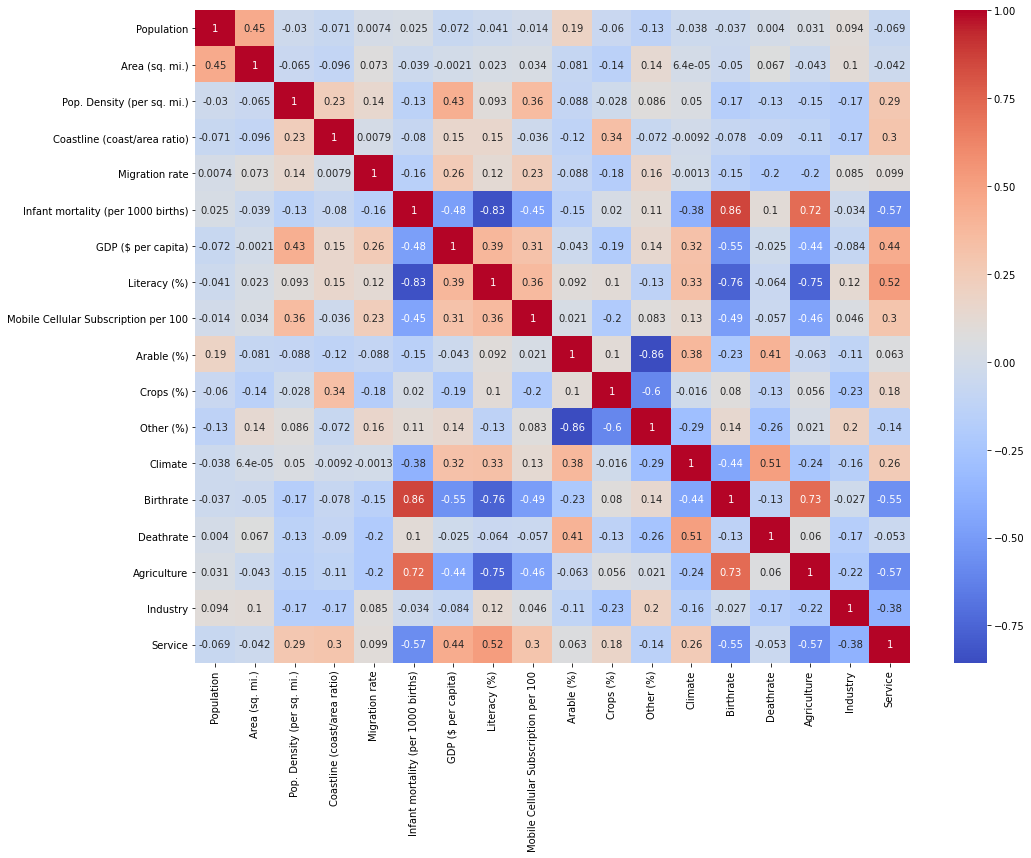

In [10]:
plt.figure(figsize=(16,12))
sns.heatmap(data=world_data.corr(),annot=True,cmap='coolwarm')
plt.show()

# Top Factors affecting GDP per capita

In [11]:
top_factors_index = world_data.corr()['GDP ($ per capita)'].abs().nlargest(7).drop('GDP ($ per capita)').index.values
top_factors = world_data.corr()['GDP ($ per capita)'][top_factors_index]
top_factors

Birthrate                            -0.545009
Infant mortality (per 1000 births)   -0.480703
Service                               0.443983
Agriculture                          -0.437506
Pop. Density (per sq. mi.)            0.428738
Literacy (%)                          0.388814
Name: GDP ($ per capita), dtype: float64

# Scatter plots for top factors

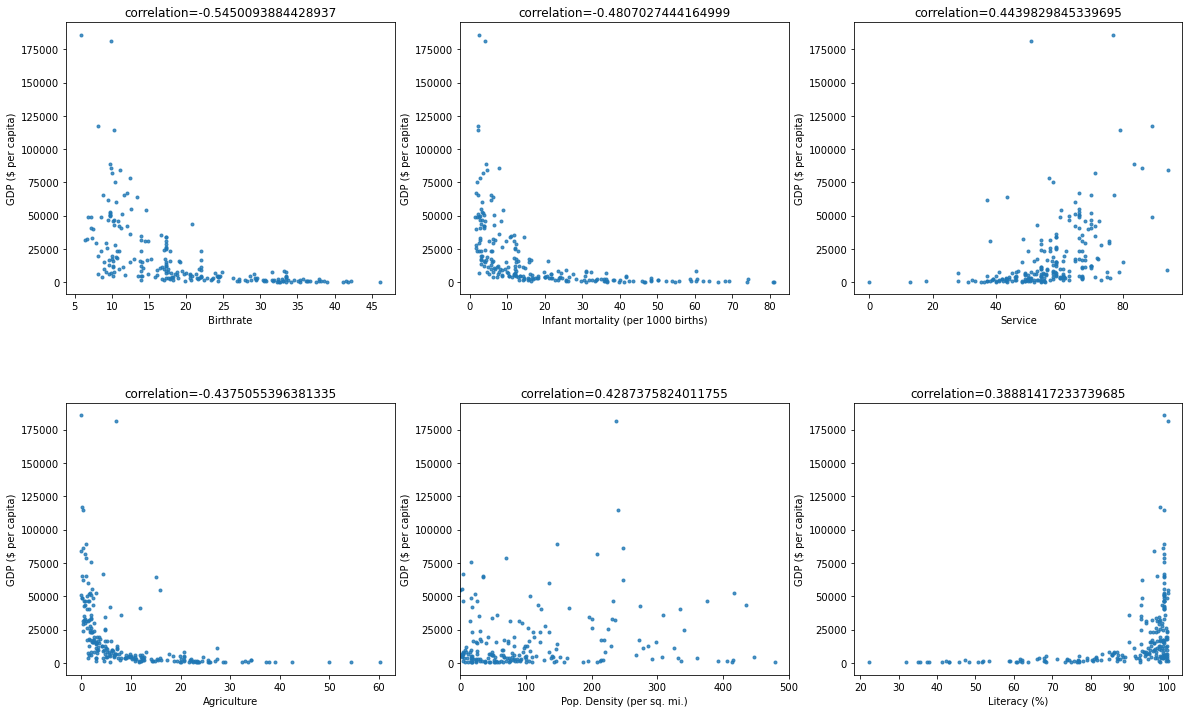

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
plt.subplots_adjust(hspace=0.4)


for i in range(2):
    for j in range(3):
        sns.regplot(x=top_factors.index.values[i*3+j], y='GDP ($ per capita)', data=world_data,
                   ax=axes[i,j], fit_reg=False, marker='.')
        title = 'correlation='+str(top_factors[i*3+j])
        axes[i,j].set_title(title)
axes[1,1].set_xlim(0,500)
plt.show()

# Modeling

In [13]:
LE = LabelEncoder()
world_data['Region_label'] = LE.fit_transform(world_data['Region'])
world_data['Climate_label'] = LE.fit_transform(world_data['Climate'])
world_data.head()

,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Migration rate,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Mobile Cellular Subscription per 100,...,Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Region_label,Climate_label
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,ASIA (EX. NEAR EAST),38041754,647500,58.75,0.00,-0.83,46.50,507.10,43.02,59.36,...,0.22,87.65,1.0,32.49,6.420,25.77,14.00,55.47,0,0
Albania,EASTERN EUROPE,2854191,28748,99.28,1.26,-2.45,8.60,5353.24,98.14,91.29,...,4.42,74.49,3.0,11.78,7.900,18.47,20.00,49.00,3,4
Algeria,NORTHERN AFRICA,43053054,2381740,18.08,0.04,-0.12,20.00,3973.96,81.41,109.36,...,0.25,96.53,1.0,24.28,4.720,12.38,37.44,46.00,6,0
American Samoa,OCEANIA,55312,199,277.95,58.29,0.00,10.25,11466.70,97.34,79.91,...,15.00,75.00,2.0,22.05,6.315,27.40,12.40,67.00,8,2
Andorra,WESTERN EUROPE,77142,468,164.83,0.00,0.00,2.80,40886.39,99.00,113.96,...,0.00,97.78,3.0,7.20,4.400,11.90,33.60,66.00,10,4


# Linear Regression

In [96]:
train, test = train_test_split(world_data, test_size=0.3, shuffle=True)
training_features = ['Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)',
       'Migration rate', 'Infant mortality (per 1000 births)',
       'Literacy (%)', 'Mobile Cellular Subscription per 100',
       'Arable (%)', 'Other (%)', 'Birthrate',
       'Deathrate', 'Agriculture', 'Industry', 'Service', 'Region_label',
       'Climate_label','Service']
target = 'GDP ($ per capita)'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

model = LinearRegression()
model.fit(train_X, train_Y)
train_pred_Y = model.predict(train_X)
test_pred_Y = model.predict(test_X)
train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=train_Y.index)
test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=test_Y.index)

rmse_train = np.sqrt(mean_squared_error(train_pred_Y, train_Y))
msle_train = mean_squared_log_error(train_pred_Y, train_Y)
rmse_test = np.sqrt(mean_squared_error(test_pred_Y, test_Y))
msle_test = mean_squared_log_error(test_pred_Y, test_Y)

print('rmse_train:',rmse_train,'msle_train:',msle_train)
print('rmse_test:',rmse_test,'msle_test:',msle_test)
print("Explain variance score =", round(explained_variance_score(test_Y, test_pred_Y), 2)) 
print("R2 score =", round(r2_score(test_Y, test_pred_Y), 2))

rmse_train: 16734.139594088374 msle_train: 9.508737638704247
rmse_test: 14801.91561202989 msle_test: 7.8922823828645425
Explain variance score = 0.73
R2 score = 0.72


Coefficient of determination for the model above comes out as 0.72

# Random Forest Regression

In [89]:
model = RandomForestRegressor(max_depth = 6)
model.fit(train_X, train_Y)
train_pred_Y = model.predict(train_X)
test_pred_Y = model.predict(test_X)
train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=train_Y.index)
test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=test_Y.index)

rmse_train = np.sqrt(mean_squared_error(train_pred_Y, train_Y))
msle_train = mean_squared_log_error(train_pred_Y, train_Y)
rmse_test = np.sqrt(mean_squared_error(test_pred_Y, test_Y))
msle_test = mean_squared_log_error(test_pred_Y, test_Y)

print('rmse_train:',rmse_train,'msle_train:',msle_train)
print('rmse_test:',rmse_test,'msle_test:',msle_test)
print("Explain variance score =", round(explained_variance_score(test_Y, test_pred_Y), 2)) 
print("R2 score =", round(r2_score(test_Y, test_pred_Y), 2))

rmse_train: 7517.679538682315 msle_train: 0.20405500638632945
rmse_test: 7158.481591594728 msle_test: 0.36320885876439757
Explain variance score = 0.85
R2 score = 0.84


Coefficient of determination for the model above comes out as 0.84

(-1000.0, 60000.0)

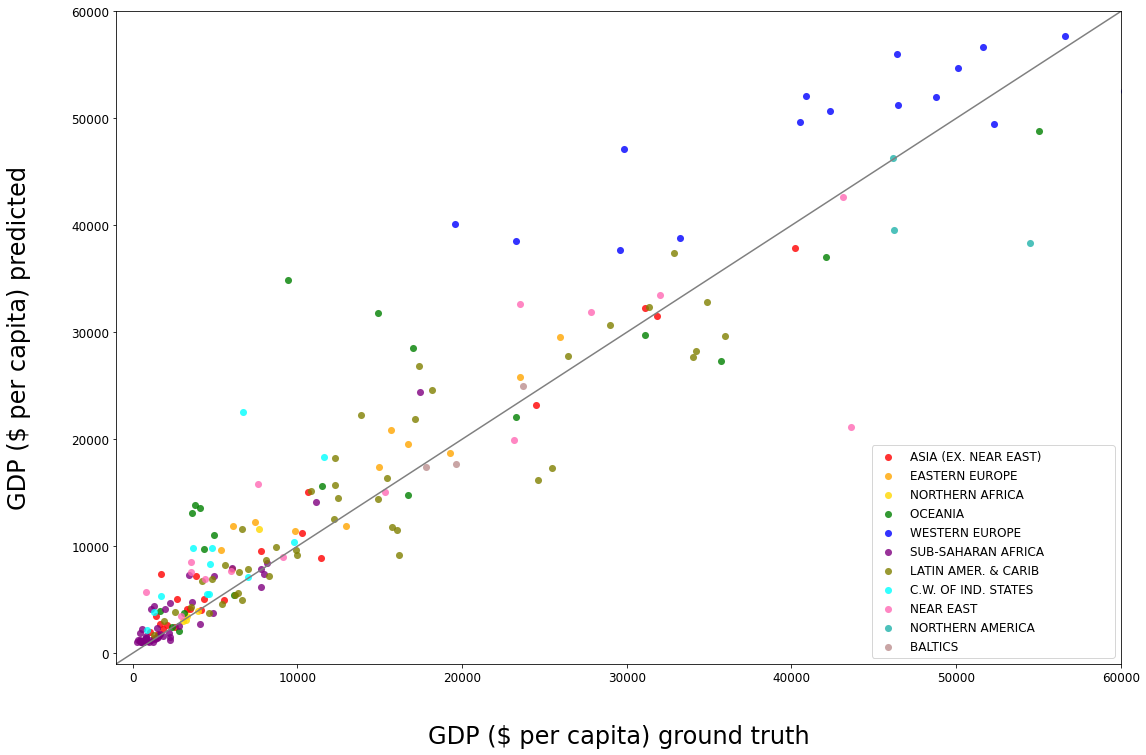

In [90]:
plt.figure(figsize=(18,12))

train_test_Y = train_Y.append(test_Y)
train_test_pred_Y = train_pred_Y.append(test_pred_Y)

data_shuffled = world_data.loc[train_test_Y.index]
label = data_shuffled.index.values

colors = {'ASIA (EX. NEAR EAST)               ':'red',
          'EASTERN EUROPE                     ':'orange',
          'NORTHERN AFRICA                    ':'gold',
          'OCEANIA                            ':'green',
          'WESTERN EUROPE                     ':'blue',
          'SUB-SAHARAN AFRICA                 ':'purple',
          'LATIN AMER. & CARIB                ':'olive',
          'C.W. OF IND. STATES                ':'cyan',
          'NEAR EAST                          ':'hotpink',
          'NORTHERN AMERICA                   ':'lightseagreen',
          'BALTICS                            ':'rosybrown'}

for region, color in colors.items():
    X = train_test_Y.loc[data_shuffled['Region']==region]
    Y = train_test_pred_Y.loc[data_shuffled['Region']==region]
    ax = sns.regplot(x=X, y=Y, marker='.', fit_reg=False, color=color, scatter_kws={'s':200, 'linewidths':0}, label=region) 
plt.legend(loc=4,prop={'size': 12})  

ax.set_xlabel('GDP ($ per capita) ground truth',labelpad=40)
ax.set_ylabel('GDP ($ per capita) predicted',labelpad=40)
ax.xaxis.label.set_fontsize(24)
ax.yaxis.label.set_fontsize(24)
ax.tick_params(labelsize=12)

x = np.linspace(-1000,60000,100) # 100 linearly spaced numbers
y = x
plt.plot(x,y,c='gray')

plt.xlim(-1000,60000)
plt.ylim(-1000,60000)
